In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from results import *

# Extract results
base_dirs = {
   'realtime': "decoder_results/realtime_results",
}
results = process_result_directories(base_dirs)
del results['realtime']['ecog_50phrases_synthesis']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Processing  ECoG_50phrases_synthesis
Processing  chance_ECoG_tm1k_synthesis
Processing  ECoG_tm1k_synthesis
Processing  chance_ECoG_50phrases_synthesis


In [7]:
from metric_utils import *

# Define comparison sets to generate sentence error rates for
comparison_sets = [
    ('gt_texts_full', 'contin_pred_text_streaming'),
    ('gt_texts_full', 'contin_asr_transcript_streaming'),
]

# generate error rates
g2p_names = [
    "realtime_ecog_tm1k_synthesis gt_texts_full_vs_contin_pred_text_streaming",
    "realtime_ecog_tm1k_synthesis gt_texts_full_vs_contin_asr_transcript_streaming",
    "realtime_chance_ecog_tm1k_synthesis gt_texts_full_vs_contin_pred_text_streaming",
    "realtime_chance_ecog_tm1k_synthesis gt_texts_full_vs_contin_asr_transcript_streaming"
]
results_summary = calculate_error_rates_and_summarize(comparison_sets, results, N=1, max_pred_words=9999, g2p_names=g2p_names)
cached_accuracy_results_summary = results_summary

realtime_chance_ecog_tm1k_synthesis gt_texts_full_vs_contin_pred_text_streaming
realtime_chance_ecog_tm1k_synthesis gt_texts_full_vs_contin_asr_transcript_streaming
realtime_ecog_tm1k_synthesis gt_texts_full_vs_contin_pred_text_streaming
realtime_ecog_tm1k_synthesis gt_texts_full_vs_contin_asr_transcript_streaming
realtime_chance_ecog_50phrases_synthesis gt_texts_full_vs_contin_pred_text_streaming


<Figure size 640x480 with 0 Axes>

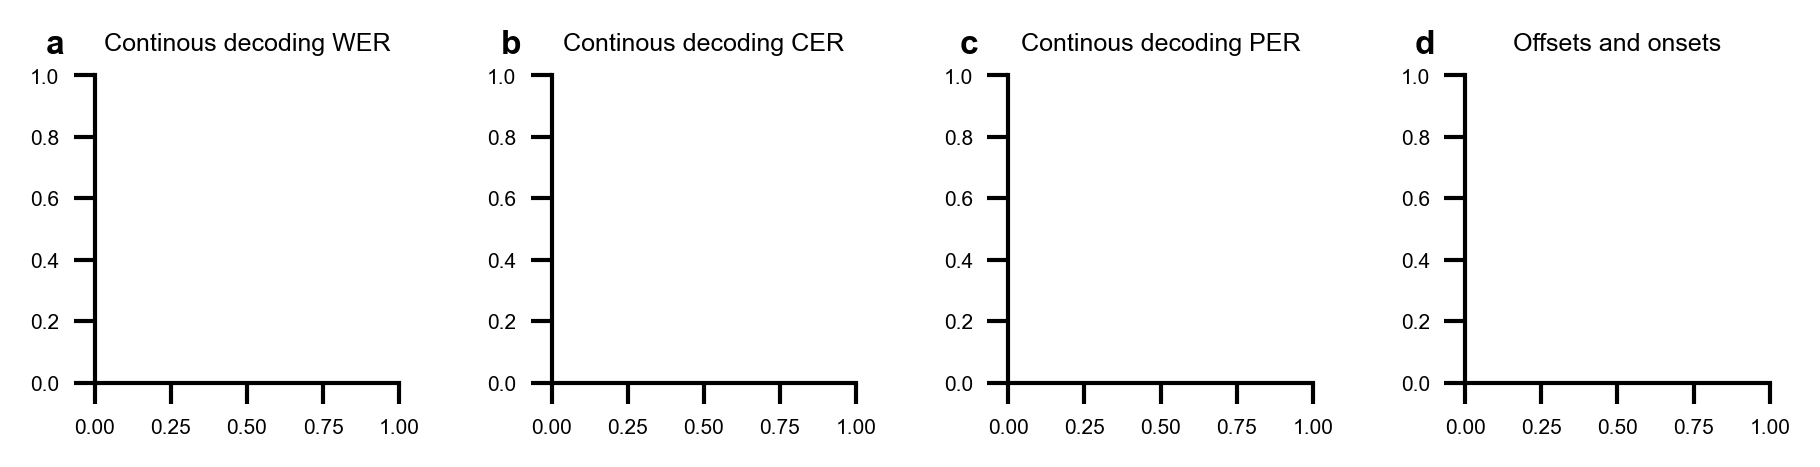

In [10]:
from results import *
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

# plotting defaults
plotting_defaults(fontsize=5)
width_in_inches = 183 / 25.4 
height_in_inches = 170 / 25.4

# initialize plot
plt.clf()
fig3 = plt.figure(figsize=(width_in_inches, height_in_inches), dpi=300)
plt.rcParams['ytick.left'] = True

# Create a GridSpec layout with more specific positions and spanning, adjusted for the new size
fig3_gs = GridSpec(16, 8, hspace=0.1, wspace=2.0)
fig3_gs_latter = GridSpec(32, 8, hspace=4.0, wspace=2.0)
titles = [
    "Continous decoding WER",
    "Continous decoding CER",
    "Continous decoding PER",
    "Offsets and onsets"
]

# p_value dictionary
stats_dict = {}

# Adjust positions according to the new GridSpec definition
positions = [
    (fig3_gs_latter[9:16, :2]),
    (fig3_gs_latter[9:16, 2:4]), 
    (fig3_gs_latter[9:16, 4:6]),
    (fig3_gs_latter[9:16, 6:8])
]
panel_letters = ['a', 'b', 'c', 'd']

# Create a dictionary to store the axes with the corrected setup
fig3_axes = create_custom_subplots(fig3, positions, titles, panel_letters)
plt.show()

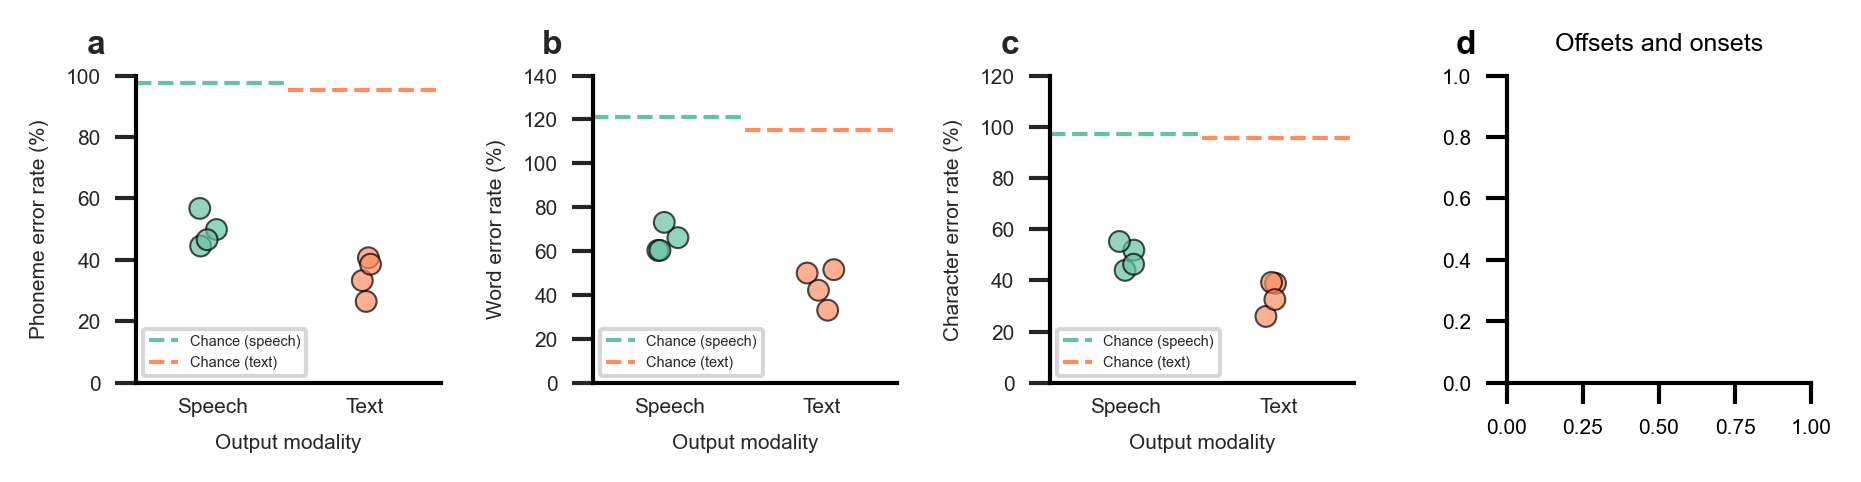

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from results import * 
from scipy.stats import wilcoxon

specified_comparisons = [
    "realtime_ecog_tm1k_synthesis gt_texts_full_vs_contin_asr_transcript_streaming", # speech
    "realtime_chance_ecog_tm1k_synthesis gt_texts_full_vs_contin_asr_transcript_streaming",
    "realtime_ecog_tm1k_synthesis gt_texts_full_vs_contin_pred_text_streaming", # text
    "realtime_chance_ecog_tm1k_synthesis gt_texts_full_vs_contin_pred_text_streaming",
]
data = []
for comparison in specified_comparisons:
    metrics = results_summary[comparison]
    modality_label = 'Speech' if 'asr_transcript' in comparison else 'Text'

    # Extract condition from comparison
    if 'chance' in comparison:
        is_chance = True
        modality_label += '\n(chance)'
    else:
        is_chance = False
    parts = comparison.split('_')
    condition_raw = '_'.join(parts[1:3]) if not is_chance else '_'.join(parts[2:4])
    condition_map = {
        'ecog_tm1k': '1024-word-General'
    }
    condition = condition_map.get(condition_raw, condition_raw)

    # Add data for WER, CER, PER, and include confidence intervals
    for metric_name in ['wers', 'cers', 'pers']:
        metric_value = metrics[metric_name]
        bootstrapped_data = get_bootstrapped_accuracies(metrics[metric_name], median=True, num_repeats=1000)
        confidence_interval = np.percentile(bootstrapped_data, [0.5, 99.5])
        lower_ci = np.median(metric_value) - confidence_interval[0]
        upper_ci = confidence_interval[1] - np.median(metric_value)
        for index, metric_value in enumerate(metrics[metric_name]):
            data_point = {
                'Condition': modality_label,
                'Modality': modality_label,
                'Metric': metric_name.upper()[:-1],  # Remove 's' and make uppercase
                'Value': metric_value * 100,
                'CI_Lower': lower_ci * 100,
                'CI_Upper': upper_ci * 100,
                'DataPointID': f"{comparison}_{metric_name}_{index}",  # Unique identifier
                'Boot': bootstrapped_data
            }
            data.append(data_point)
df = pd.DataFrame(data)


mean_chance_speech_per = df[df['Condition'].apply(lambda x: x == 'Speech\n(chance)') & (df['Metric'] == 'PER')]['Value'].mean()
mean_chance_text_per = df[df['Condition'].apply(lambda x: x == 'Text\n(chance)') & (df['Metric'] == 'PER')]['Value'].mean()
mean_chance_speech_wer = df[df['Condition'].apply(lambda x: x == 'Speech\n(chance)') & (df['Metric'] == 'WER')]['Value'].mean()
mean_chance_text_wer = df[df['Condition'].apply(lambda x: x == 'Text\n(chance)') & (df['Metric'] == 'WER')]['Value'].mean()
mean_chance_speech_cer = df[df['Condition'].apply(lambda x: x == 'Speech\n(chance)') & (df['Metric'] == 'CER')]['Value'].mean()
mean_chance_text_cer = df[df['Condition'].apply(lambda x: x == 'Text\n(chance)') & (df['Metric'] == 'CER')]['Value'].mean()

# Perform Wilcoxon rank-sum tests for Speech vs. Speech Chance and Text vs. Text Chance
for met in ['PER', 'WER', 'CER']:
    stats_dict[f'contin_{met.lower()}'] = {}
    val = np.array(df[(df['Condition'] == 'Speech') & (df['Metric'] == met)]['Boot'])[0]
    chance_val =  np.array(df[(df['Condition'] == 'Speech\n(chance)') & (df['Metric'] == met)]['Boot'])[0]
    stat, p = wilcoxon(val, chance_val)
    test_result_label = (('1024-word-General', f"Speech"), ('1024-word-General', "Chance"))
    stats_dict[f'contin_{met.lower()}'][test_result_label] = (stat, p)
    val = np.array(df[(df['Condition'] == 'Text') & (df['Metric'] == met)]['Boot'])[0]
    chance_val = np.array(df[(df['Condition'] == 'Text\n(chance)') & (df['Metric'] == met)]['Boot'])[0]
    stat, p = wilcoxon(val, chance_val)
    test_result_label = (('1024-word-General', f"Text"), ('1024-word-General', "Chance"))
    stats_dict[f'contin_{met.lower()}'][test_result_label] = (stat, p)

# Common settings for the plots
sns.set_style("white")
plt.rcParams['ytick.left'] = True
palette = sns.color_palette("Set2")
modality_order = ['Speech', 'Text']
condition_order = ['1024-word-General']

# Phoneme Error Rate Plot
ax = fig3_axes['a']
ax.cla()
ax.text(-0.1, 1.15, f"a", transform=ax.transAxes, fontsize=8, va='top', ha='right', fontdict={'weight': 'bold'})
phoneme_df = df[df['Metric'] == 'PER']
plot_df = phoneme_df[~phoneme_df['Condition'].str.contains('chance')]
sns.stripplot(x='Condition', y='Value', hue='Modality', hue_order=modality_order,
              data=plot_df, ax=ax, palette=palette, dodge=False, edgecolor='black', linewidth=0.5, alpha=0.7)
ax.set_ylim(0, 100)
ax.set_title(None)
ax.set_ylabel('Phoneme error rate (%)')
ax.set_xlabel('Output modality')
ax.get_legend().remove()
halfway = len(phoneme_df['Condition'].unique()) / 2
l1 = ax.axhline(mean_chance_speech_per, ls='--', color=palette[0], xmin=0, xmax=0.5)
l2 = ax.axhline(mean_chance_text_per, ls='--', color=palette[1], xmin=0.5, xmax=1)
ax.set_yticks(np.arange(0, 120, 20))
ax.tick_params(axis='x', length=0)
ax.legend([l1, l2], ['Chance (speech)', 'Chance (text)'], loc='lower left', fontsize='x-small')

# Word Error Rate Plot
ax = fig3_axes['b']
ax.cla()
ax.text(-0.1, 1.15, f"b", transform=ax.transAxes, fontsize=8, va='top', ha='right', fontdict={'weight': 'bold'})
word_df = df[df['Metric'] == 'WER']
plot_df = word_df[~word_df['Condition'].str.contains('chance')]
sns.stripplot(x='Condition', y='Value', hue='Modality', hue_order=modality_order,
              data=plot_df, ax=ax, palette=palette, dodge=False, edgecolor='black', linewidth=0.5, alpha=0.7)
ax.set_ylabel('Word error rate (%)')
ax.set_title(None)
ax.set_xlabel('Output modality')
ax.set_ylim(0, 140)
ax.get_legend().remove()
l1 = ax.axhline(mean_chance_speech_wer, ls='--', color=palette[0], xmin=0, xmax=0.5)
l2 = ax.axhline(mean_chance_text_wer, ls='--', color=palette[1], xmin=0.5, xmax=1)
ax.set_yticks(np.arange(0, 160, 20))
ax.tick_params(axis='x', length=0)
ax.legend([l1, l2], ['Chance (speech)', 'Chance (text)'], loc='lower left', fontsize='x-small')

# Character Error Rate Plot
ax = fig3_axes['c']
ax.cla()
ax.text(-0.1, 1.15, f"c", transform=ax.transAxes, fontsize=8, va='top', ha='right', fontdict={'weight': 'bold'})
char_df = df[df['Metric'] == 'CER']
plot_df = char_df[~char_df['Condition'].str.contains('chance')]
sns.stripplot(x='Condition', y='Value', hue='Modality', hue_order=modality_order,
              data=plot_df, ax=ax, palette=palette, dodge=False, edgecolor='black', linewidth=0.5, alpha=0.7)
ax.set_ylabel('Character error rate (%)')
ax.set_title(None)
ax.set_xlabel('Output modality')
ax.set_ylim(0, 120)
ax.get_legend().remove()
l1 = ax.axhline(mean_chance_speech_cer, ls='--', color=palette[0], xmin=0, xmax=0.5)
l2 = ax.axhline(mean_chance_text_cer, ls='--', color=palette[1], xmin=0.5, xmax=1)
ax.set_yticks(np.arange(0, 140, 20))
ax.tick_params(axis='x', length=0)
ax.legend([l1, l2], ['Chance (speech)', 'Chance (text)'], loc='lower left', fontsize='x-small')

display(fig3)

Number of intervals with speech outside detected onset/offset: 3
Number of intervals with no speech inside detected onset/offset: 2


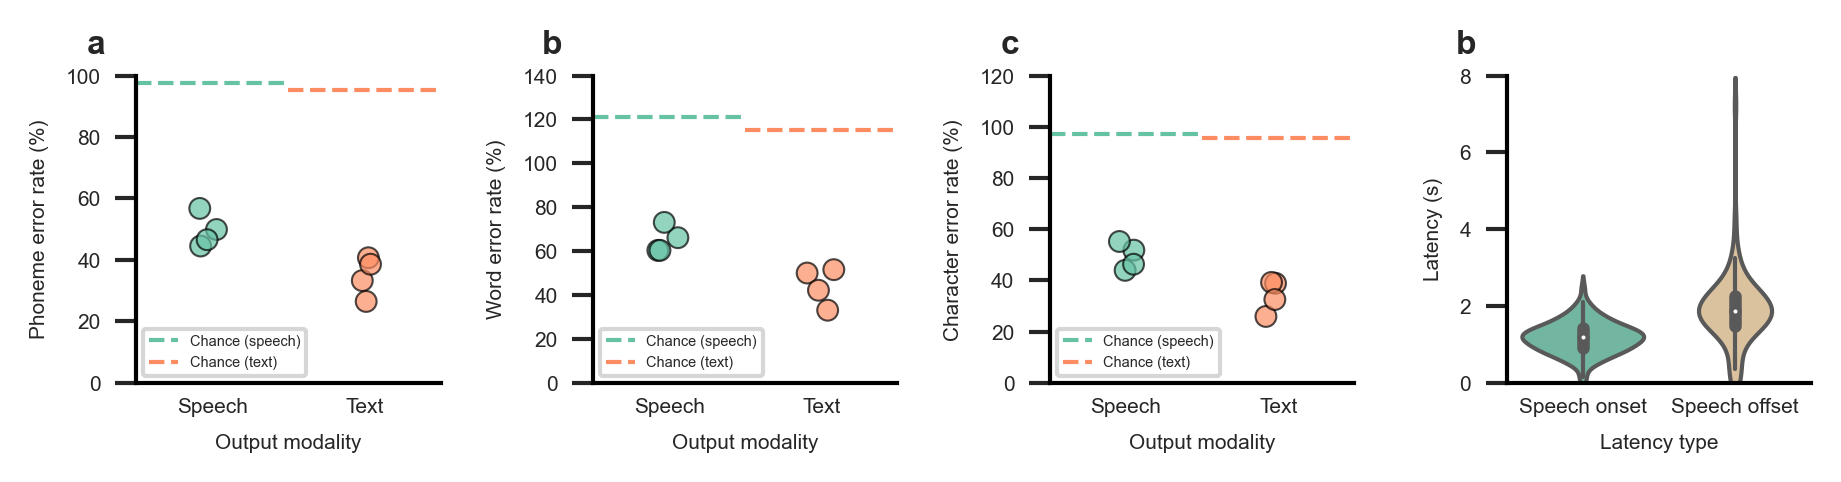

In [17]:
#### import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tqdm

audio_fs = 16000
neural_sr = 200
onset_latencies = []
offset_latencies = []
speech_outside_detected_intervals = 0
no_speech_inside_detected_intervals = 0
speech_inside_intervals = []
speech_outside_intervals = []
run_det = True

for blck in [0, 1, 2, 3]:
    pred_wav = results['realtime']['ecog_tm1k_synthesis']['contin_pred_audio_streaming'][str(blck)]
    first_cue = results['realtime']['ecog_tm1k_synthesis']['event_time'][str(int(blck * 25))][0]
    last_cue = results['realtime']['ecog_tm1k_synthesis']['event_time'][str(int((blck + 1) * 25 - 1))][0]
    
    # Index active region of block (from time of first sample to decoder to start + length of audio)
    window = [-1.0, 8.0]
    start_event_index = int(blck * 25)
    start_window = int(window[0] * neural_sr)
    start_event_time = first_cue * neural_sr
    first_decoder_sample = int(np.round(start_event_time + start_window))
    last_event_index = int((blck + 1) * 25 - 1)
    last_window = int(window[1] * neural_sr)
    last_event_time = last_cue * neural_sr
    last_decoder_sample = int(np.round(last_event_time + last_window))
    
    # Get params
    T_audio = len(pred_wav) / audio_fs / 60
    T_feats = T_audio
    assert T_feats == T_audio
    T = T_feats
    onsets, offsets, timecourse = vad_onset_offset(pred_wav, audio_fs)
    
    # Get onsets and offsets relative to the first cue
    modified_wav = np.zeros_like(pred_wav)
    sample_onsets = (np.array(onsets) * audio_fs).astype(int)
    sample_offsets = (np.array(offsets) * audio_fs).astype(int)
    for onset, offset in zip(sample_onsets, sample_offsets):
        modified_wav[onset:offset] = pred_wav[onset:offset]  
    true_onsets, true_offsets, _ = vad_onset_offset(modified_wav, audio_fs)
    true_onsets = [x + window[0] for x in true_onsets]
    true_offsets = [x + window[0] for x in true_offsets]

    def find_nearest(pred, true):
        nearest = min(true, key=lambda x: abs(x - pred))
        return nearest
    
    # Compute latencies for each trial using nearest neighbor lookup
    prev_pred_end = 0
    prev_event_time = 0
    for trial in np.arange(25 * blck, 25 * (blck + 1)):
        
        # Get all results relative to the first cue
        pred_start = results['realtime']['ecog_tm1k_synthesis']['predicted_start'][str(trial)] - first_cue
        pred_end = results['realtime']['ecog_tm1k_synthesis']['predicted_end'][str(trial)] - first_cue
        event_time = results['realtime']['ecog_tm1k_synthesis']['event_time'][str(trial)][0] - first_cue
        
        # Find the nearest true onset and offset
        nearest_true_onset = find_nearest(pred_start, true_onsets)
        nearest_true_offset = find_nearest(pred_end, true_offsets)
        
        # Compute latencies
        trial_onset_latency = np.abs(pred_start - nearest_true_onset)
        trial_offset_latency = np.abs(pred_end - nearest_true_offset)
        

        # check if speech occurs inside or outside the detected interval
        if run_det:
            if any(prev_pred_end > 0 and prev_pred_end < onset < event_time + window[0] and \
                                         prev_event_time + window[1] + 2.4 < onset < event_time - 0.5 for onset in true_onsets):
                speech_outside_detected_intervals += 1
            pred_interval = np.arange(pred_start * audio_fs, pred_end * audio_fs)
            current_true_intervals_set = set()
            for start, end in zip(true_onsets, true_offsets):
                if start >= prev_pred_end and end <= pred_end:
                    current_true_intervals_set.update(range(int(start * audio_fs), int(end * audio_fs)))
            pred_interval_set = set(np.arange(int(pred_start * audio_fs), int(pred_end * audio_fs)))
            if not pred_interval_set & current_true_intervals_set:
                no_speech_inside_detected_intervals += 1
            else:
                thresh = 10.0
                if trial_onset_latency > thresh or trial_offset_latency > thresh:
                    print(blck, trial, trial_onset_latency, trial_offset_latency)
                else:
                    onset_latencies.append(trial_onset_latency)
                    offset_latencies.append(trial_offset_latency)
            prev_pred_end = pred_end
            prev_event_time = event_time

print(f"Number of intervals with speech outside detected onset/offset: {speech_outside_detected_intervals}")
print(f"Number of intervals with no speech inside detected onset/offset: {no_speech_inside_detected_intervals}")

# Bootstrapped latencies
bootstrapped_data = get_bootstrapped_accuracies(onset_latencies, median=True, num_repeats=1000)
confidence_interval = (np.percentile(bootstrapped_data,0.5).round(decimals=3), np.percentile(bootstrapped_data,99.5).round(decimals=3))
bootstrapped_data = get_bootstrapped_accuracies(offset_latencies, median=True, num_repeats=1000)
confidence_interval = (np.percentile(bootstrapped_data,0.5).round(decimals=3), np.percentile(bootstrapped_data,99.5).round(decimals=3))

# Create a DataFrame
latency_data = {'Condition': ['Speech onset'] * len(onset_latencies) + ['Speech offset'] * len(offset_latencies),
                'Latency': onset_latencies + offset_latencies}
df_latencies = pd.DataFrame(latency_data)

# Plot the violin plot
ax = fig3_axes['d']
ax.cla()
color_set = "Set2"
palette = [sns.color_palette(color_set)[0], sns.color_palette(color_set)[6]]
ax.text(-0.1, 1.15, "b", transform=ax.transAxes, fontsize=8, va='top', ha='right', fontdict={'weight': 'bold'})
ax.set_ylim(0, 8.0)
sns.violinplot(x='Condition', y='Latency', data=df_latencies, ax=ax, palette=palette)
ax.set_ylabel("Latency (s)")
ax.set_xlabel("Latency type")
ax.tick_params(axis='x', length=0)
display(fig3)